声明：此实践来自于 [R2RT大神博客中的RNN in Tensorflow的两篇教程之一](https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html), 版权归R2RT所有，不妥删，感谢R2RT大神以及评论中的一些大神对于概率算法的的解释。



## 数据概要

我们要创建的是一个没有修饰的 RNN，此 RNN 接收一个二进制序列 X，输出一个二进制序列 Y。序列的具体内容如下所述：
+ 输入序列(X):在t时间步长，X<sub>t</sub> 有 50% 的概率成为 1(50% 的概率成为 0)。例如，X为[1,0,1,1,0,0,....]
+ 输出序列(y): 在t时间步长，Y<sub>t</sub> 有 50% 的概率成为 1(50% 的概率成为 0)。而当X<sub>t-3</sub>为1时，Y为1的概率要加上50%，变为100%；当X<sub>t-8</sub>为1时，Y为1的概率要减去25%，变为25%；如果X<sub>t-3</sub>和X<sub>t-8</sub>同时为1，则Y为1的概率为50%+50%-25%=75%

因此会分别在X<sub>t-3</sub>和X<sub>t-8</sub>这两处有依赖关系。

这个数据非常简单，我们可以根据是否学习依赖关系来计算训练RNN的期望交叉熵损失：
+ 当网络没有学习任何依赖关系：那么它将正确地分配概率为62.5%，交叉熵的损失大概为0.66
+ 当网络只学习到X<sub>t-3</sub>这个依赖关系：那么它将在50%的时间中正确地分配概率为87.5％，并且正确地分配其他50％时间的概率为62.5％ ，预期的交叉熵损失约为0.52。
+ 当网络只学习到X<sub>t-8</sub>这个依赖关系：那么它将在25％的时间内100％准确，25％的时间分配一个概率为50%，并另外的50%时间正确率为75％，预期的交叉熵损失约为0.45。


这里是代码实现的交叉熵计算：

In [2]:
import numpy as np

print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) + 
                                        0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learn first dependency: ", 
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.6615632381579821
- learn first dependency:  0.5191666997072094
- learns both dependencies:  0.4544543674493905


## 模型结构

这个模型将会尽可能的简单：在时间步 t ，t∈{0,1,…n}，该模型接收一个二进制向量(one-hot向量) X<sub>t</sub> 和前一个状态向量 S<sub>t-1</sub> 作为输入，生成一个状态向量 S<sub>t</sub> 和一个预测概率分布的向量 P<sub>t</sub> 作为二进制输出向量 Y<sub>t</sub>。

形式上，这个模型是这样的：

*S<sub>t</sub>* = *tanh (W(X<sub>t</sub> @ S<sub>t-1</sub>) + b<sub>s</sub>)*
（@ 表示向量级联）

*P<sub>t</sub>* = *softmax(US<sub>t</sub> + b<sub>p</sub>)*

下面是模型的图片：

![](https://r2rt.com/static/images/BasicRNN.png)

## TensorFlow 图形的宽度应该为多少？

要在 Tensorflow 中建立模型，首先将模型表示为图形，然后执行图形。在决定如何表示我们的模型时，我们必须回答的一个关键问题是：我们的图应该有多宽？我们的图形应该同时接受多少时间步长的输入？

每个时间步都是一个副本，所以可以认为把我们的计算图 G 表示成单个时间步 G(X<sub>t</sub>, S<sub>t-1</sub>)→(P<sub>t</sub>, S<sub>t</sub>)。我们可以在每个时间步里计算我们的计算图，即将从前一次执行返回的状态送入当前执行。这适用于已经训练过的模型，但是使用这种方法进行训练存在一个问题：反向传播期间计算的梯度是图形限制的。我们只能将错误反向传播到当前时间步；而不能将错误反向传播到时间步t-1。这意味着我们的网络将无法学习如何在其状态中存储长期依赖关系（如我们的数据中的两个依赖关系）
或者，我们可以使我们的图像与我们的数据序列一样宽。这通常是有效的，除了在我们这种情况下，我们有一个任意长的输入序列，所以我们必须在某个地方停下来。假设我们让图形接受长度为 10,000 的序列。这解决了图形界限梯度的问题，并且时间步 9999 的错误一直传播到时间步0。不幸的是，由于消失/爆炸的梯度问题，这种反向传播不仅（通常过于耗费计算）耗时，而且也是无效的。事实证明，经过太多时间步骤反向传播错误经常导致它们消失（变得微不足道）或爆炸（变得压倒性地大）。

因此处理非常长序列的通常模式是通过反向传播错误来“截断”我们的反向传播，最大限度地取 n 个 step。我们选择 n 作为我们模型的超参数，记住这个权衡：**更高 n 让我们捕获更长期的依赖关系，但在计算和存储方面更为昂贵。**

对于最大限度地取 n 个 step 的反向传播的自然解释是在 n 个 step 中返回每个可能的 error。也就是说，如果我们有一个长度为 49 的序列，并选择 n = 7，我们会反复传播整个 7 个步骤中的 42 个错误。这不是我们在 Tensorflow 中采用的方法。 Tensorflow 的方法是限制图形 为 n 个 units 宽。请参阅 Tensorflow 关于截断反向传播的[书面报告](https://www.tensorflow.org/versions/r0.9/tutorials/recurrent/index.html#truncated-backpropagation)（“[截断后向传播]可以通过提供长度[n]，并在每次迭代之后进行反向传递。“）。这意味着我们将采用长度为 49 的序列，将其分解为 7 个长度为 7 的子序列，然后我们将 7 个子序列输入到 7 个单独的计算中，并且只有来自每个图中第 7 个输入的错误会被反向传播到全部的 7 个步骤。因此，即使认为数据中没有超过 7 个步骤的依赖关系，也仍然值得使用 n > 7，以增加反向传播 7 个错误的比例。对于反向传播每个错误之间差异的实证研究 n 步骤和 Tensorflow 式反向传播，请参阅[Styles of Truncated Backpropagation](https://r2rt.com/styles-of-truncated-backpropagation.html)。


## 使用张量列表(tensor list)来表示宽度

我们的图将是 n 个 units (time steps)宽，并且每个 unit 都是一个完美的副本，共享同样的参数。最简单的创建方法就是在水平方向上排列每个副本。
这是一个关键点，所以我对它加粗：**表示每种类型的重复张量（rnn 输入，rnn 输出（隐藏状态），预测和损失）的最简单方式是张量列表(tensor list)。**

下面是一个图表，其中引用了后面代码中使用的变量：

   ![](https://r2rt.com/static/images/BasicRNNLabeled.png)

我们将在每次执行计算图后执行一个训练步骤，同时抓取该执行产生的最终状态以传递给下一次执行。

下面是实现的代码：

In [2]:
# Imports
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Global config variables
num_steps = 1 # numbers of truncated backprop steps
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [4]:
def gen_data(size=10000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold +=0.5
        if X[i-8] == 1:
            threshold -=0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    
    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length// batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
        # futher divide batch partitions into num_steps for truncated backprop
        epoch_size = batch_partition_length // num_steps
        
        for i in range(epoch_size):
            x = data_x[:, i * num_steps: (i + 1) * num_steps]
            y = data_y[:, i * num_steps: (i + 1) * num_steps]
            yield (x, y)
            
def gen_epochs(n, num_steps):
        for i in range(n):
            yield gen_batch(gen_data(), batch_size, num_steps)
            

In [5]:
## Model
# placholders
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

#RNN Inputs
# Turn our placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

In [6]:
"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    
def rnn_cell(rnn_inputs, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [7]:
"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [8]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""
# logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y paceholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

# losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [9]:
'''
Train the network
'''

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = sess.run([losses, total_loss, final_state, train_step],feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose :
                        print("Average loss at step", step, "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
                    
    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.05387661042623222
Average loss at step 200 for last 250 steps: 0.05302148465067148
Average loss at step 300 for last 250 steps: 0.06820753829553723
Average loss at step 400 for last 250 steps: 0.07868318939581513
Average loss at step 500 for last 250 steps: 0.09179187256842852
Average loss at step 600 for last 250 steps: 0.10077756393700837
Average loss at step 700 for last 250 steps: 0.09237503703683615
Average loss at step 800 for last 250 steps: 0.0716840036213398
Average loss at step 900 for last 250 steps: 0.07364892676472663
Average loss at step 1000 for last 250 steps: 0.08009612746536732
Average loss at step 1100 for last 250 steps: 0.08186865448951722
Average loss at step 1200 for last 250 steps: 0.08364877440035343
Average loss at step 1300 for last 250 steps: 0.08732572585344314
Average loss at step 1400 for last 250 steps: 0.0925115343183279
Average loss at step 1500 for last 250 steps: 0.09851390942931175
Average loss

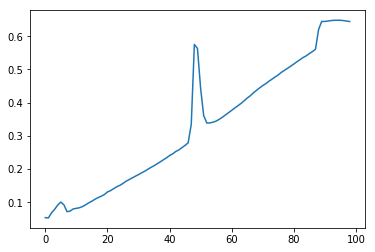

In [11]:
training_losses = train_network(1,num_steps)
plt.plot(training_losses)

In [10]:
import basic_rnn
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

def plot_learning_curve(num_steps, state_size=4, epochs=1):
    global losses, total_loss, final_state, train_step, x, y, init_state
    tf.reset_default_graph()
    g = tf.get_default_graph()
    losses, total_loss, final_state, train_step, x, y, init_state = \
        basic_rnn.setup_graph(g,
            basic_rnn.RNN_config(num_steps=num_steps, state_size=state_size))
    res = train_network(epochs, num_steps, state_size=state_size, verbose=False)
    plt.plot(res)

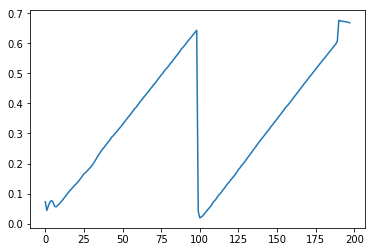

In [10]:
"""
NUM_STEPS = 1
"""
plot_learning_curve(num_steps=1, state_size=4, epochs=2)

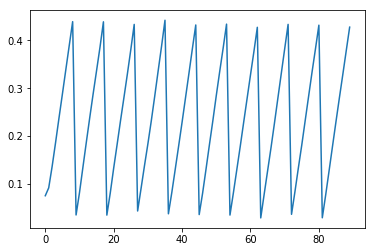

In [11]:
"""
NUM_STEPS = 10
"""
plot_learning_curve(num_steps=10, state_size=16, epochs=10)

## 将模型转换为 TensorFlow 

使用Tensorflow’s API 来训练我们的模型是简单的。 我们只要将下面两个单元替换掉：

In [5]:
"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

用这两行代码来取代：

In [6]:
cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)

## 静态方法

我们在执行之前将每个时间步的每个节点添加到图中。这被称为“静态”。

In [5]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)

"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, num=num_steps, axis=1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

## 动态方法

我们也可以让Tensorflow在执行时动态创建图形，这可以更有效。

In [4]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

rnn_inputs = tf.one_hot(x, num_classes)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = tf.reshape(
            tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
            [batch_size, num_steps, num_classes])
predictions = tf.nn.softmax(logits)

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)